# MCMC Orbit

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.jplhorizons import Horizons

import emcee
from corner import corner

from jorbit import Particle, Observations
from jorbit.data.constants import SPEED_OF_LIGHT
from jorbit.utils.states import KeplerianState, CartesianState

/Users/cassese/Documents/Work/Code/jorbit/src/jorbit/particle.py:177: RuntimeWarning: Warning: initial Gauss's method fit produced an unbound orbit
  self._fit_seed = self._setup_fit_seed(fit_seed)


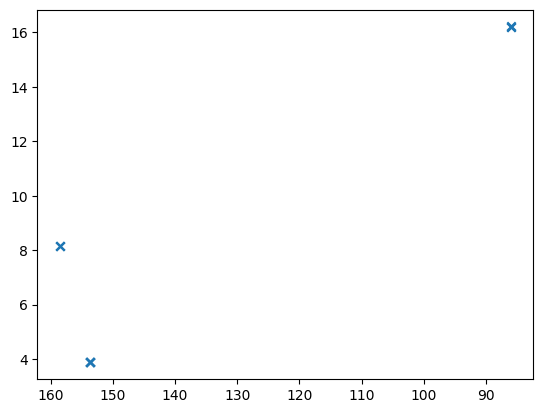

In [15]:
nights = [Time("2025-01-01 07:00"), Time("2025-01-02 07:00"), Time("2025-07-05 07:00"), Time("2027-10-05 07:00")]

times = []
for n in nights:
    times.extend([n + i * 1 * u.hour for i in range(3)])
times = Time(times)

obj = Horizons(id="274301", location="695@399", epochs=times.utc.jd)
pts = obj.ephemerides(extra_precision=True, quantities="1")

coords = SkyCoord(pts["RA"], pts["DEC"], unit=(u.deg, u.deg))
times = Time(pts["datetime_jd"], format="jd", scale="utc")

fig, ax = plt.subplots()
ax.scatter(coords.ra.deg, coords.dec.deg, marker="x")
ax.invert_xaxis()

obs = Observations(
    observed_coordinates=coords,
    times=times,
    observatories="kitt peak",
    astrometric_uncertainties=1 * u.arcsec,
)

ti = times[0] - 1 * u.hour
wiki = Particle.from_horizons("274301", time=ti, observations=obs)

In [16]:
@jax.jit
def loglike(elements_vec):
    state = KeplerianState(
        semi=jnp.array([elements_vec[0]]),
        ecc=jnp.array([elements_vec[1]]),
        nu=jnp.array([elements_vec[2]]),
        inc=jnp.array([elements_vec[3]]),
        Omega=jnp.array([elements_vec[4]]),
        omega=jnp.array([elements_vec[5]]),
        acceleration_func_kwargs={},
        time=ti.tdb.jd,
    )
    resids = wiki.static_residuals(state)

    quad = jnp.einsum(
        "bi,bij,bj->b", resids, wiki.observations.inv_cov_matrices, resids
    )

    ll = jnp.sum(
        -0.5 * (2 * jnp.log(2 * jnp.pi) + wiki.observations.cov_log_dets + quad)
    )
    return ll


x0 = jnp.squeeze(
    jnp.array(
        [
            wiki.keplerian_state.semi,
            wiki.keplerian_state.ecc,
            wiki.keplerian_state.nu,
            wiki.keplerian_state.inc,
            wiki.keplerian_state.Omega,
            wiki.keplerian_state.omega,
        ]
    )
)
loglike(x0)

Array(-22.0545248, dtype=float64)

In [17]:
x0 = jax.random.normal(jax.random.PRNGKey(0), shape=(18, 6)) * 1e-2 + x0

nwalkers = 18
sampler = emcee.EnsembleSampler(nwalkers, 6, loglike)
sampler.run_mcmc(x0, 25_000, progress=True);

100%|██████████| 25000/25000 [19:43<00:00, 21.12it/s]


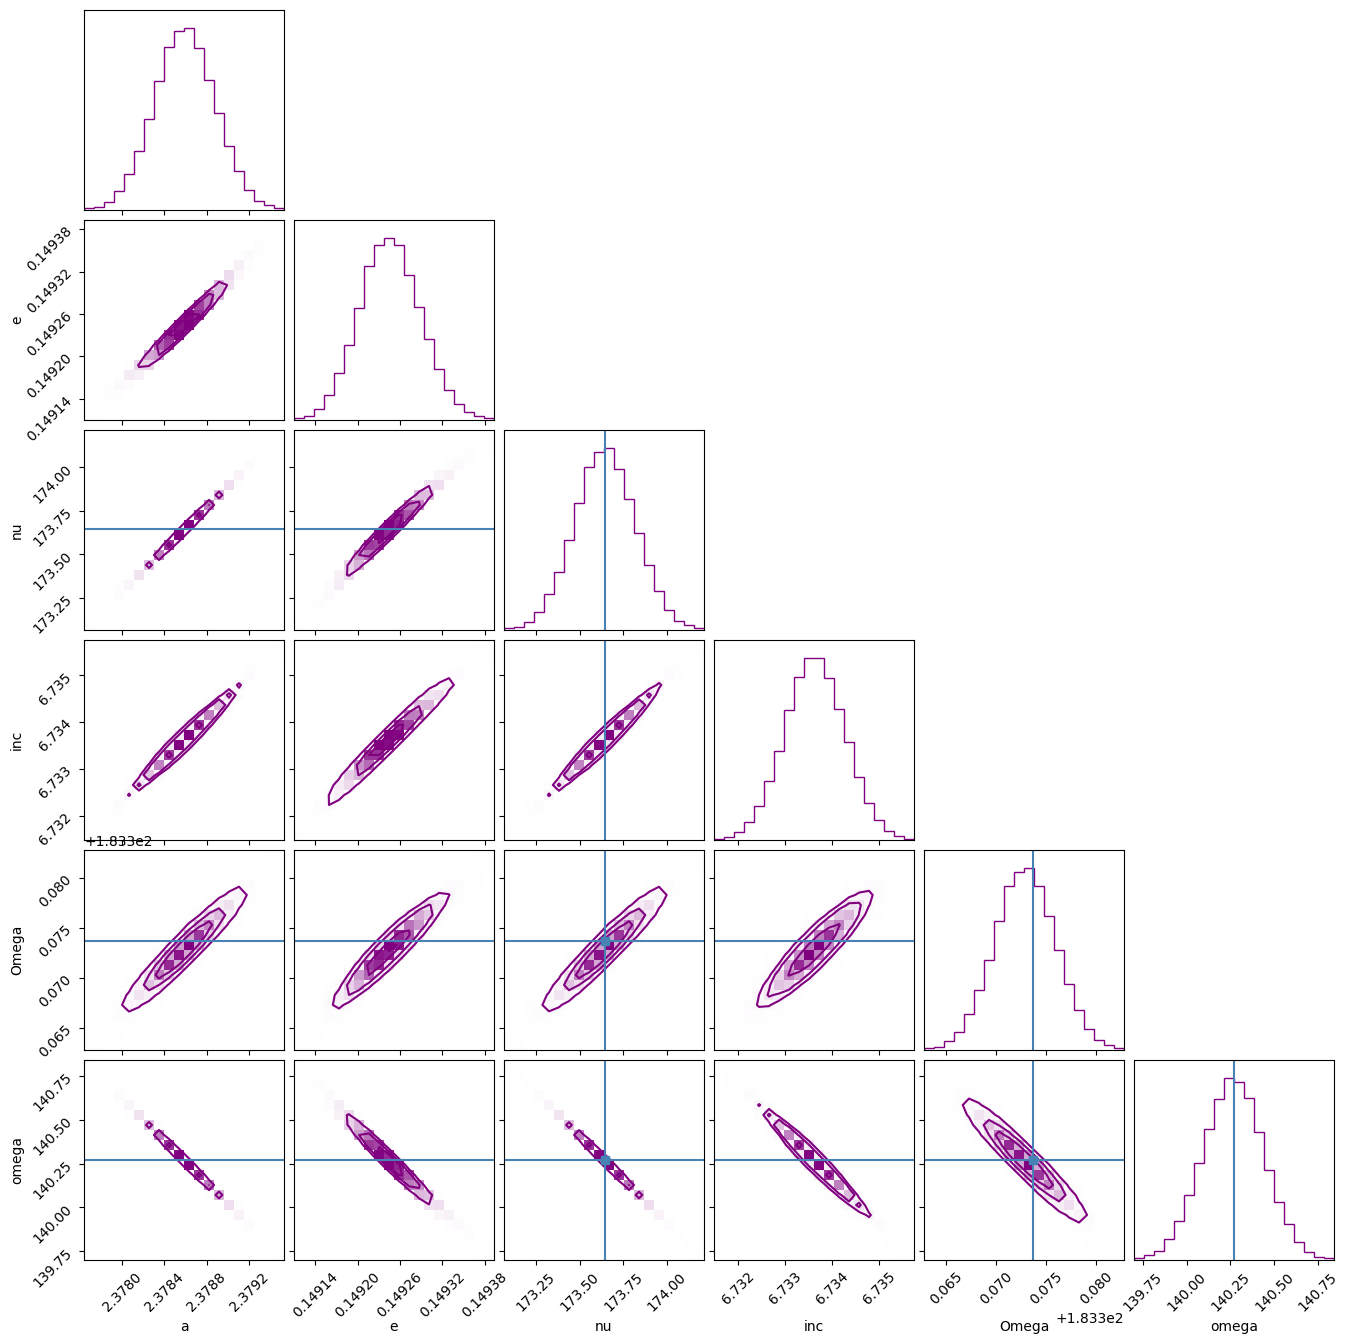

In [20]:
samples = sampler.get_chain(flat=True, thin=5, discard=5_000)

fig = corner(
    samples,
    labels=["a", "e", "nu", "inc", "Omega", "omega"],
    truths=x0[0],
    color="purple",
    plot_datapoints=False,
    range=jnp.repeat(0.999, 6),
)

In [ ]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.jplhorizons import Horizons

import emcee
from corner import corner

from jorbit import Particle, Observations
from jorbit.data.constants import SPEED_OF_LIGHT
from jorbit.utils.states import KeplerianState, CartesianState

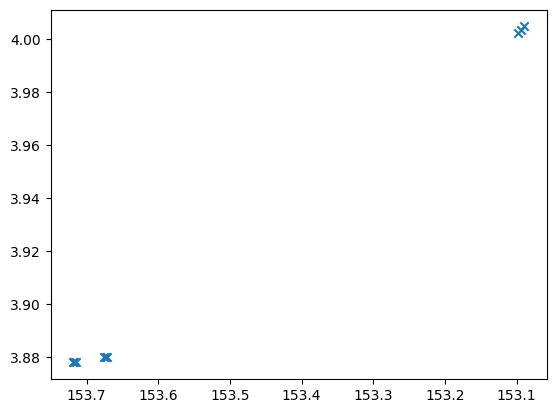

In [21]:
nights = [Time("2025-01-01 07:00"), Time("2025-01-02 07:00"), Time("2025-01-10 07:00")]

times = []
for n in nights:
    times.extend([n + i * 1 * u.hour for i in range(3)])
times = Time(times)

obj = Horizons(id="274301", location="695@399", epochs=times.utc.jd)
pts = obj.ephemerides(extra_precision=True, quantities="1")

coords = SkyCoord(pts["RA"], pts["DEC"], unit=(u.deg, u.deg))
times = Time(pts["datetime_jd"], format="jd", scale="utc")

fig, ax = plt.subplots()
ax.scatter(coords.ra.deg, coords.dec.deg, marker="x")
ax.invert_xaxis()

obs = Observations(
    observed_coordinates=coords,
    times=times,
    observatories="kitt peak",
    astrometric_uncertainties=1 * u.arcsec,
)

ti = times[0] - 1 * u.hour
wiki = Particle.from_horizons("274301", time=ti, observations=obs)

In [22]:
@jax.jit
def loglike(elements_vec):
    state = KeplerianState(
        semi=jnp.array([elements_vec[0]]),
        ecc=jnp.array([elements_vec[1]]),
        nu=jnp.array([elements_vec[2]]),
        inc=jnp.array([elements_vec[3]]),
        Omega=jnp.array([elements_vec[4]]),
        omega=jnp.array([elements_vec[5]]),
        acceleration_func_kwargs={},
        time=ti.tdb.jd,
    )
    resids = wiki.static_residuals(state)

    quad = jnp.einsum(
        "bi,bij,bj->b", resids, wiki.observations.inv_cov_matrices, resids
    )

    ll = jnp.sum(
        -0.5 * (2 * jnp.log(2 * jnp.pi) + wiki.observations.cov_log_dets + quad)
    )
    return ll


x0 = jnp.squeeze(
    jnp.array(
        [
            wiki.keplerian_state.semi,
            wiki.keplerian_state.ecc,
            wiki.keplerian_state.nu,
            wiki.keplerian_state.inc,
            wiki.keplerian_state.Omega,
            wiki.keplerian_state.omega,
        ]
    )
)
loglike(x0)

Array(-16.5408936, dtype=float64)

In [23]:
x0 = jax.random.normal(jax.random.PRNGKey(0), shape=(18, 6)) * 1e-2 + x0

nwalkers = 18
sampler = emcee.EnsembleSampler(nwalkers, 6, loglike)
sampler.run_mcmc(x0, 50_000, progress=True);

100%|██████████| 50000/50000 [1:03:56<00:00, 13.03it/s]  


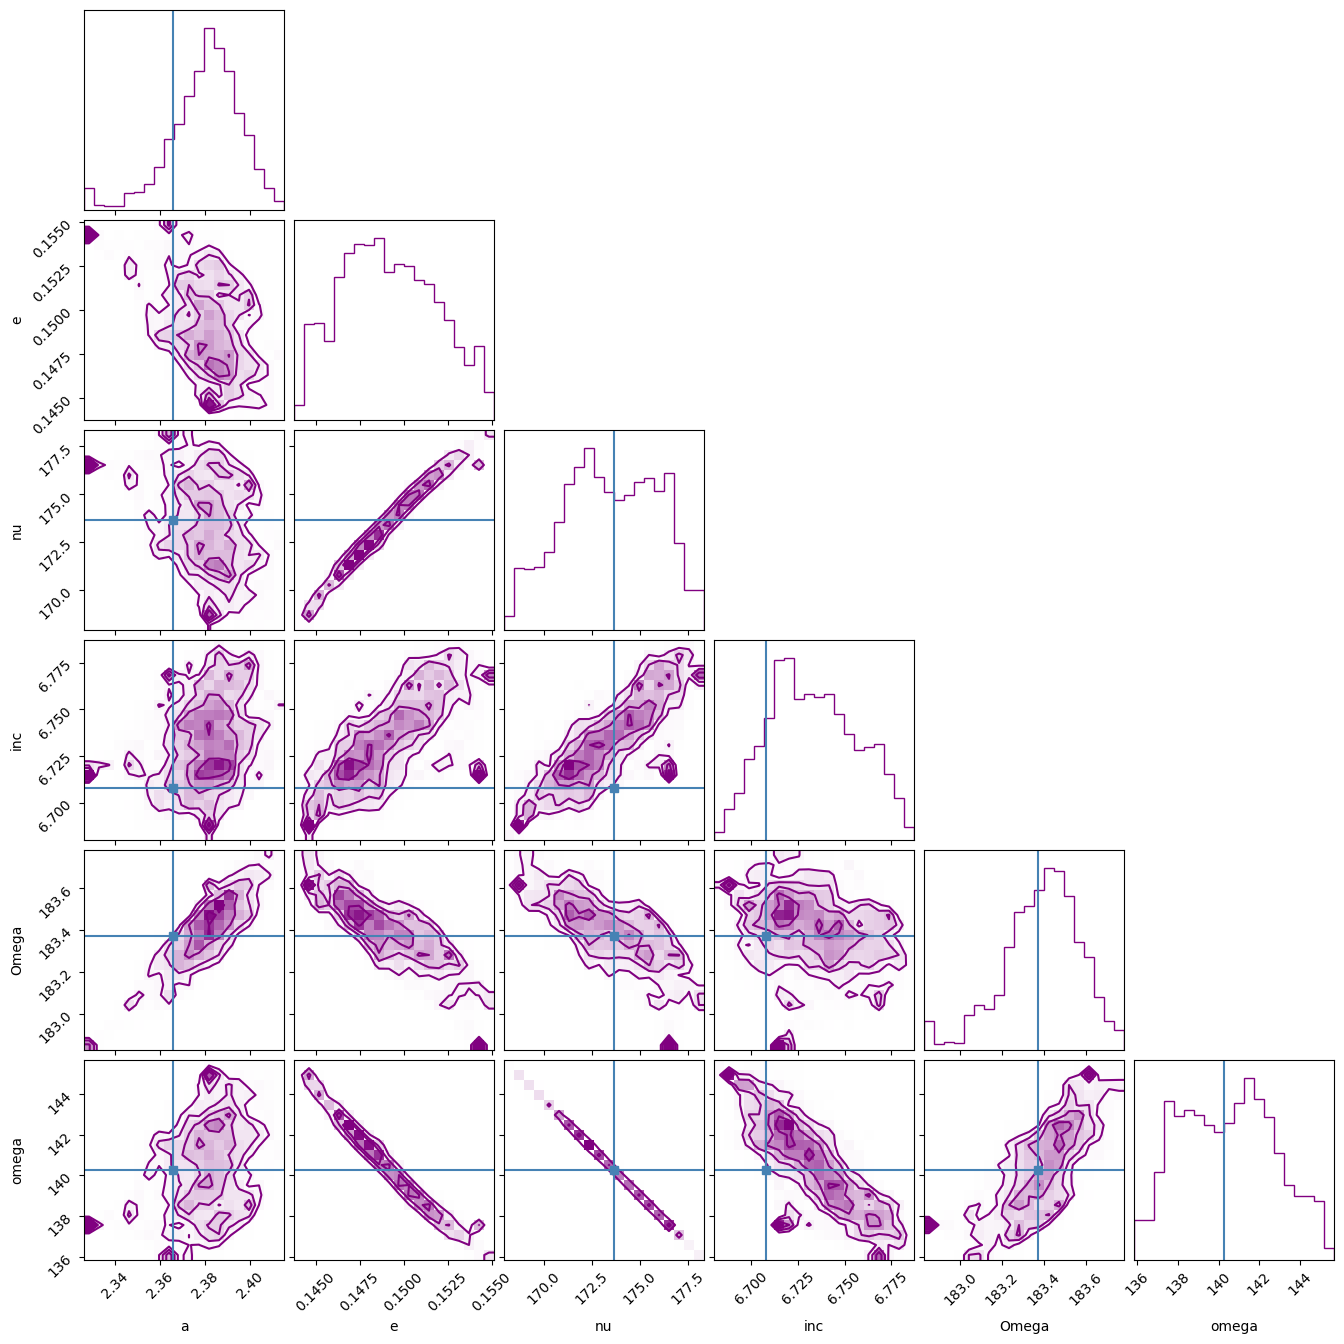

In [24]:
samples = sampler.get_chain(flat=True, thin=5, discard=5_000)

fig = corner(
    samples,
    labels=["a", "e", "nu", "inc", "Omega", "omega"],
    truths=x0[0],
    color="purple",
    plot_datapoints=False,
    range=jnp.repeat(0.999, 6),
)

Thanks. You can also see that I've written a verision of the IAS15 integrator (well, not necessary "15", since you can use higher-orders) that uses the mpmath library for arbitrary precision calculations in jorbit.integrators.iasnn_arbitrary_prec. Like you did for the doubledouble version of ppn_gravity, can you add another file under accelerations that uses mpmath for an arbitrary precision version of ppn_gravity? I won't use this in production, but I want to be able to test the accuracy of the double-double version against it.